In [6]:
from scipy.special import logsumexp

In [28]:
import scipy.io.wavfile as wavfile
from sklearn.model_selection import train_test_split
import os
from hmmlearn import hmm
import MFCC
import numpy as np
import re
import random
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from glob import glob   #use glob bc apparently Quinlan said to in class and I trust Jake the Cupcake

## Problem 1

Write a function which accepts a GMMHMM as well as
an integer n_sim, and which simulates the GMMHMM process, generating n_sim different
observations. Use the example GMMHMM to sample 900 times. Use PCA from SkLearn to plot your generated observations in 2D space. Color observations by state.

In [16]:
def sample_gmmhmm(gmmhmm, n_sim):
    """
    Simulate from a GMMHMM.
    
    Returns
    -------
    states : ndarray of shape (n_sim,)
        The sequence of states
    obs : ndarray of shape (n_sim, M)
        The generated observations (vectors of length M)
    """
    #need steps to randomly sample from GMMHMM so need 1st initialize state, sample_comp, sample
    state, sample_component, sample = [], [], []
    
    #these steps come from yellow box in lab manual:
    #choose initial state
    state.append(np.argmax(np.random.multinomial(1, gmmhmm[-1])))
    
    #randomly select component using probability weights of current state
    sample_component.append(np.argmax(np.random.multinomial(1, gmmhmm[1][state[-1],:])))
    
    #sample an observation from selected GMM Gaussian component:
    sample.append(np.random.multivariate_normal(gmmhmm[2][state[-1], sample_component[-1], :],
                                               gmmhmm[3][state[-1], sample_component[-1], :, :]))
    
    #want generate n_sim different observations so loop through it all
    for n in range(n_sim-1):
        #obtain next state using transition matrix
        state.append(np.argmax(np.random.multinomial(1, gmmhmm[0][:, state[-1]])))
        
        #then do the whole process over again:
        #so, randomly select component using prob weights of current state
        sample_component.append(np.argmax(np.random.multinomial(1, gmmhmm[1][state[-1], :])))
        
        #sample an obs from selected GMM Gaussian component:
        sample.append(np.random.multivariate_normal(gmmhmm[2][state[-1], sample_component[-1], :],
                                                   gmmhmm[3][state[-1], sample_component[-1], :]))
        
    
    return np.array(state), np.array(sample)   #want return the states and observations as arrays

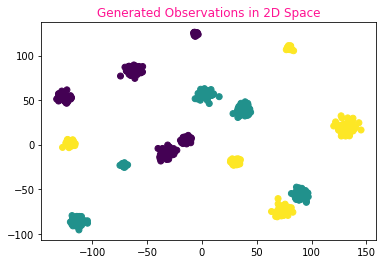

In [21]:
#run it on gmmhmm given in example w/ T=900
#use sklearn.decomposition.PCA w/ 2 components to plot obs in 2D space
#color obs by state

#will follow process given in 1st yellow box in lab manual, follow those same steps:

#NxN transition matrix
A = np.array([[.3, .3, .4], [.2, .3, .5], [.3, .2, .5]])

#NxK collection of component weights
weights = np.array([[.3, .2, .1, .2, .2], [.1, .3, .3, .2, .1], [.1, .3, .2, .1, .3]])

#NxKxM collection of component means
means = np.array([np.floor(np.random.uniform(-100, 100, size = (5, 4))) for i in range(3)])

#NxKx(MxM) collection of component covariance matrices
covars = np.array([[np.floor(np.random.uniform(1, 20))*np.eye(4) for i in range(5)] for j in range(3)])

#(N,) ndarray initial state distribution
pi = np.array([.15, .15, .7])

#Save the model parameters
gmm = [A, weights, means, covars, pi]

#get states, obs need for using gmmhmm
states, obs = sample_gmmhmm(gmm, 900)                  #want use T=900
obs = PCA(2).fit_transform(obs)  #want 2 components

#plot it NOWWWWWWW
plt.scatter(obs[:,0], obs[:,1], c = states)
plt.title("Generated Observations in 2D Space", color = "deeppink")
plt.show()

I see 3 clusters from the graph.

## Problem 2

Samples.zip contains 30 recordings for each of the words/phrases mathematics, biology, political science, psychology, and statistics. These audio samples are 2 seconds in
duration, recorded at a rate of 44100 samples per second, with samples stored as 16-bit signed
integers in WAV format. 
Load the recordings into Python using scipy.io.wavfile.read

Extract the MFCCs from each sample using code from the file MFCC.py.
Store the MFCCs for each word in a separate list. You should have five lists, each containing
30 MFCC arrays, corresponding to each of the five words under consideration.

/tmp/ipykernel_11297/2073165383.py:18: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(m)        #load wavfile
/tmp/ipykernel_11297/2073165383.py:24: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(b)        #load wavfile
/tmp/ipykernel_11297/2073165383.py:30: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(p)        #load wavfile
/tmp/ipykernel_11297/2073165383.py:36: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(p)        #load wavfile
/tmp/ipykernel_11297/2073165383.py:42: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, data = wavfile.read(s)        #load wavfile


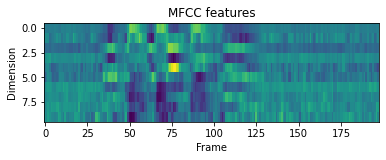

In [24]:
#get the files that need:
da_files = glob('Samples/*.wav')
da_files = [file for file in da_files if '00' not in file]  #remove 00 bc lab manual said so!
    
#get all of the separate lists for all of the different files have from Samples folder, booYUH baby!
mat = [file for file in da_files if 'Mathematics' in file]
bio = [file for file in da_files if 'Biology' in file]
pol = [file for file in da_files if 'PoliticalScience' in file]
psy = [file for file in da_files if 'Psychology' in file]
sta = [file for file in da_files if 'Statistics' in file]
    
#initialize empty lists for each of the different subjects:
math, biol, poly, psych, stats = [], [], [], [], []
    
#now fill for all 5 categories using load, extract method given:
#do for math
for m in mat:
    samplerate, data = wavfile.read(m)        #load wavfile
    model = MFCC.extract(data, show = False)  #extract MFCC
    math.append(model)
        
#do for bio
for b in bio:
    samplerate, data = wavfile.read(b)        #load wavfile
    model = MFCC.extract(data, show = False)  #extract MFCC
    biol.append(model)
        
#do for political science
for p in pol:
    samplerate, data = wavfile.read(p)        #load wavfile
    model = MFCC.extract(data, show = False)  #extract MFCC
    poly.append(model)
    
#do for pscyh:
for p in psy:
    samplerate, data = wavfile.read(p)        #load wavfile
    model = MFCC.extract(data, show = False)  #extract MFCC
    psych.append(model)
        
#do for stats:
for s in sta:
    samplerate, data = wavfile.read(s)        #load wavfile
    model = MFCC.extract(data, show = False)  #extract MFCC
    stats.append(model)        

## Problem 3

Partition each list of MFCCs into a training set of 20 samples, and a test set of
the remaining 10 samples.
Using the training sets, train a GMMHMM on each of the words from the previous problem
with at least 10 random restarts, keeping the best model for each word (the one with the highest
log-likelihood).

In [25]:
def initialize(n_states):
    transmat = np.ones((n_states,n_states))/float(n_states)
    for i in range(n_states):
        transmat[i,:] += np.random.uniform(-1./n_states,1./n_states,n_states)
        transmat[i,:] /= sum(transmat[i,:])
    startprob = np.ones(n_states)/float(n_states) + np.random.uniform(-1./n_states,1./n_states,n_states)
    startprob /= sum(startprob)
    return startprob, transmat

In [33]:
#use training sets, train GMMHMM on each of words from prev prob w/ @ least 10 random restarts
#so get the training, testing sets for each of the 5 categories
math_train, math_test = train_test_split(math, test_size = .33)
bio_train, bio_test = train_test_split(biol, test_size = .33)
poly_train, poly_test = train_test_split(poly, test_size = .33)
psych_train, psych_test = train_test_split(psych, test_size = .33)
stats_train, stats_test = train_test_split(stats, test_size = .33)

#get all of our training samples (want 5 for training)
train_samples = {"math": math_train,
                "biology": bio_train,
                "politic": poly_train,
                "psychology": psych_train,
                "statistic": stats_train}

best_model = {}  #will store all of the best models here!

#loop through our training sample
for word in train_samples:
    #best model is one w/ highest log likelihood (prob), so will compare w/ -inf bc will all be bigger than it
    max_ting = -np.inf
    
    #5 iterations because have 5 n_components
    for i in range(5):
        #this code comes from the lab manual, boo-freaking-YUH!
        data = train_samples[word] # Reshape data for hmmlearn's fit method
        lengths = [data[0].shape[0]] * len(data)
        data_collected = np.vstack(data)
        
        #get the probs and transition matrix via initialize func
        start_prob, trans_m = initialize(5)
        
        #initialize the model
        model = hmm.GMMHMM(n_components = 5, covariance_type = "diag", init_params = "mc")
        
        #set prob and transition matrices w/ model:
        model.startprob_ = start_prob
        model.transmat_ = trans_m
        
        #fit the model
        model.fit(data_collected)
        
        #get best model for each word
        if model.monitor_.history[-1] > max_ting:
            max_ting = model.monitor_.history[-1]
            best_model[word] = model

#want the best model here!
print(best_model)

{'math': GMMHMM(covars_prior=array([[[-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5, -1.5]]]),
       covars_weight=array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0...
       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]),
       init_params='mc',
       means_prior=array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]]),
       means_weight=array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]]),
       n_components=5,
       weights_prior=array([[1.],
       [1.],
       [1.],
       [1.]

## Problem 4

Find the classification accuracies of the five GMMHMMs, and return a dictionary
where the words/phrases are the keys, and the values are the percent accuracies.

In [37]:
#initialize the accuracy:
accuracy = {}
for word in train_samples:
    accuracy[word] = 0      #initialize it as 0
    
#initialize the tests:
test_samples = {"math": math_test,
                "biology": bio_test,
                "politic": poly_test,
                "psychology": psych_test,
                "statistic": stats_test}

#follow instructions given in lab manual for how to find the accuracy
#iterate through each sample of each test set:
for test in test_samples:
    #iterate through each array in each test (have multiple in each test)
    for array in test_samples[test]:
        #set the maximum as a very low number like how did in prob 3
        max_ting = -np.inf

        #iterate through each best_model keys
        for key in best_model:
            #check if we have the best model
            if (best_model[key].score(array) > max_ting):
                temp_ting = key
                max_ting = best_model[key].score(array)

        #check if bets key is the same as the test:
        if (temp_ting == test):
            accuracy[test] += .1

print(accuracy)

{'math': 0.9999999999999999, 'biology': 0.7999999999999999, 'politic': 1.0999999999999999, 'psychology': 0.8999999999999999, 'statistic': 0.9999999999999999}
